In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Feb 11 18:35:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   68C    P2             176W / 450W |  15760MiB / 24564MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 64
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.4892578125
encoder.convs 5.989013671875
encoder.linear 0.500244140625
prior 0.0
latent 0.0
decoder 6.528697967529297
decoder.linear 0.5078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 81220
-rw-rw-r-- 1 scpark scpark  1105968  2월 11 18:35 events.out.tfevents.1707643369.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 41028436  2월 11 18:33 save_10000
-rw-rw-r-- 1 scpark scpark 41022572  2월 11 18:22 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


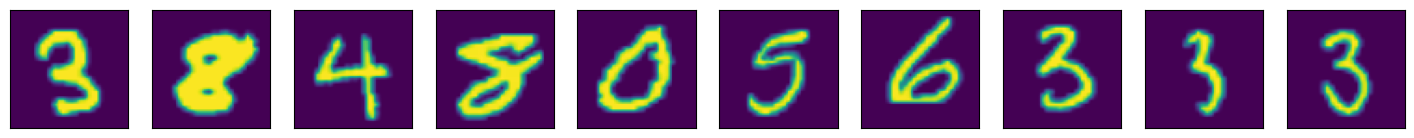

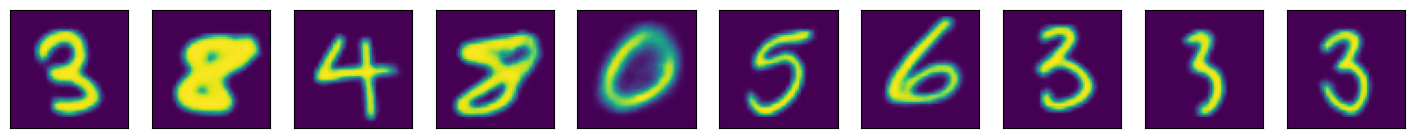

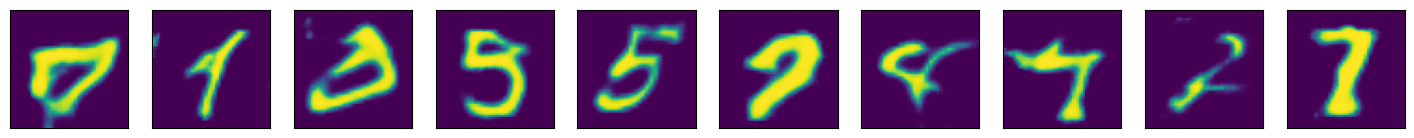

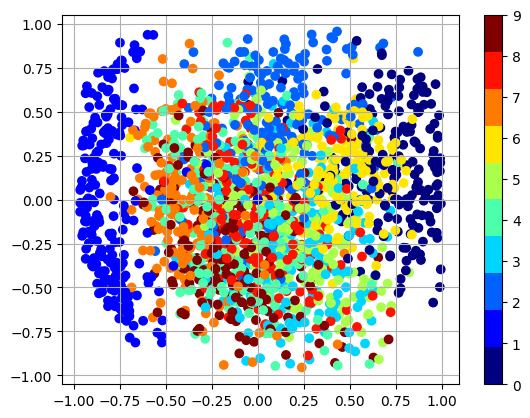

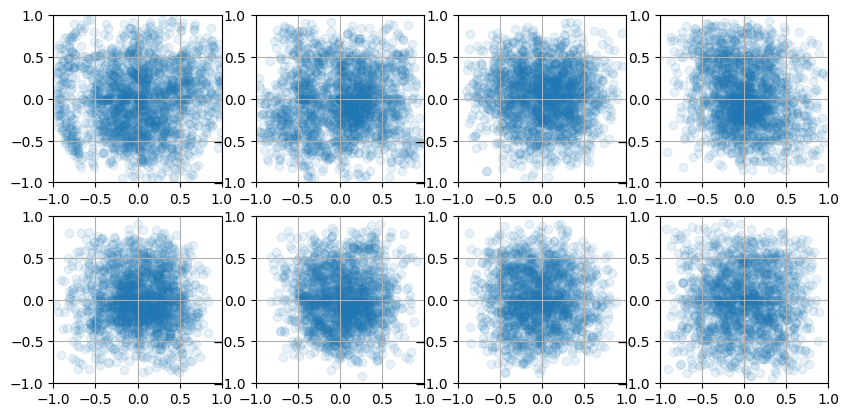

10001
swae_loss 0.010336806997656822
recon_loss 0.025660691782832146
10002
swae_loss 0.007677250541746616
recon_loss 0.03030136041343212
10003
swae_loss 0.008738920092582703
recon_loss 0.03201241046190262
10004
swae_loss 0.008206971921026707
recon_loss 0.023067656904459
10005
swae_loss 0.009385760873556137
recon_loss 0.02811928652226925
10006
swae_loss 0.011505779810249805
recon_loss 0.032063499093055725
10007
swae_loss 0.009074819274246693
recon_loss 0.02726801484823227
10008
swae_loss 0.009645776823163033
recon_loss 0.02905549667775631
10009
swae_loss 0.010138103738427162
recon_loss 0.0333319790661335
10010
swae_loss 0.01112939789891243
recon_loss 0.03103257343173027
10011
swae_loss 0.0072260526940226555
recon_loss 0.03256228193640709
10012
swae_loss 0.009428556077182293
recon_loss 0.03033125028014183
10013
swae_loss 0.009716263972222805
recon_loss 0.02726845070719719
10014
swae_loss 0.009879513643682003
recon_loss 0.02759433165192604
10015
swae_loss 0.010939502157270908
recon_loss 0

10124
swae_loss 0.00851393211632967
recon_loss 0.030568141490221024
10125
swae_loss 0.009244879707694054
recon_loss 0.03166242688894272
10126
swae_loss 0.011642401106655598
recon_loss 0.02640940248966217
10127
swae_loss 0.00979272834956646
recon_loss 0.025915026664733887
10128
swae_loss 0.00811484269797802
recon_loss 0.02811511978507042
10129
swae_loss 0.010044672526419163
recon_loss 0.028547611087560654
10130
swae_loss 0.008755958639085293
recon_loss 0.02211708389222622
10131
swae_loss 0.011398236267268658
recon_loss 0.030230190604925156
10132
swae_loss 0.00892493687570095
recon_loss 0.031210502609610558
10133
swae_loss 0.008947348222136497
recon_loss 0.02343391440808773
10134
swae_loss 0.009997964836657047
recon_loss 0.032268039882183075
10135
swae_loss 0.010495040565729141
recon_loss 0.026689331978559494
10136
swae_loss 0.009256954304873943
recon_loss 0.023798171430826187
10137
swae_loss 0.01006031222641468
recon_loss 0.029074808582663536
10138
swae_loss 0.009179300628602505
recon_l

swae_loss 0.009807508438825607
recon_loss 0.025494106113910675
10246
swae_loss 0.009856474585831165
recon_loss 0.029326148331165314
10247
swae_loss 0.009930221363902092
recon_loss 0.02820379100739956
10248
swae_loss 0.008315839804708958
recon_loss 0.027459539473056793
10249
swae_loss 0.010708519257605076
recon_loss 0.03781125694513321
10250
swae_loss 0.008610584773123264
recon_loss 0.029510878026485443
10251
swae_loss 0.00871931854635477
recon_loss 0.025383692234754562
10252
swae_loss 0.008161067962646484
recon_loss 0.03234034776687622
10253
swae_loss 0.008743127807974815
recon_loss 0.03186846897006035
10254
swae_loss 0.009273628704249859
recon_loss 0.028594207018613815
10255
swae_loss 0.007710855919867754
recon_loss 0.032800398766994476
10256
swae_loss 0.011579238809645176
recon_loss 0.02840939164161682
10257
swae_loss 0.008777745999395847
recon_loss 0.030636783689260483
10258
swae_loss 0.01060687005519867
recon_loss 0.02493041753768921
10259
swae_loss 0.00811395701020956
recon_loss 0

swae_loss 0.009897983632981777
recon_loss 0.02881579101085663
10369
swae_loss 0.010521539486944675
recon_loss 0.029453668743371964
10370
swae_loss 0.008681459352374077
recon_loss 0.025278478860855103
10371
swae_loss 0.0096038319170475
recon_loss 0.024562429636716843
10372
swae_loss 0.009995043277740479
recon_loss 0.03275386989116669
10373
swae_loss 0.008608613163232803
recon_loss 0.033965256065130234
10374
swae_loss 0.009463245049118996
recon_loss 0.027029339224100113
10375
swae_loss 0.00910730566829443
recon_loss 0.026839282363653183
10376
swae_loss 0.010516350157558918
recon_loss 0.028787121176719666
10377
swae_loss 0.01057371310889721
recon_loss 0.029089707881212234
10378
swae_loss 0.008965219371020794
recon_loss 0.028248850256204605
10379
swae_loss 0.009300592355430126
recon_loss 0.02812541276216507
10380
swae_loss 0.008492529392242432
recon_loss 0.03219904750585556
10381
swae_loss 0.008576765656471252
recon_loss 0.02800193428993225
10382
swae_loss 0.00960966944694519
recon_loss 0.


KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()